In [ ]:
import pickle
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound

eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"
%matplotlib widget

In [ ]:
def plotc2_cap(all_sumvars_dict1,all_sumvars_dict2,esoh_data,leg1="sim1",leg2="sim2"):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    name = "Capacity [A.h]"
    ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict1[name],"b--")
    ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict2[name],"r--")
    ax.plot(esoh_data["N"],esoh_data[name],"kx")
    ax.set_title(split_long_string(name))
    ax.set_xlabel("Cycle number")
    fig.legend([leg1, leg2 , "Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.05], ncol=3, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
cells = [1,4,7,10,13,16,19]
# cells = [19]
for cell in cells:
    sno = 1
    sim_des = f'cond{sno}'
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    sno = 6
    sim_des = f'cond{sno}'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data2 = pickle.load(handle)
    fig = plotc2_cap(data1,data2,dfe,leg1="Old",leg2="New Mech Damage");
    fig.savefig(fig_DIR +'com_mech_damage_model_cell_'+cell_no+'_cap.png')

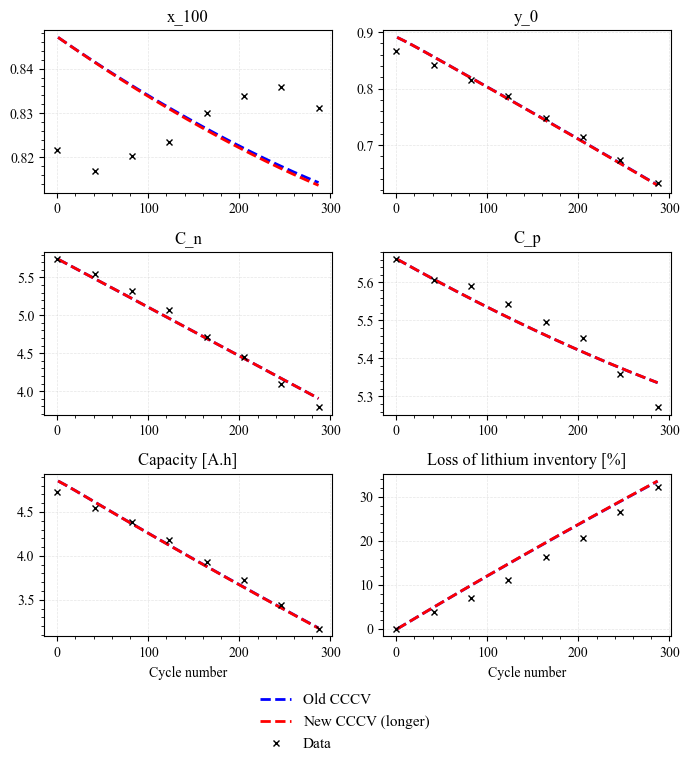

In [4]:
cells = [1,4,7,10,13,16,19]
cells = [4]
for cell in cells:
    sno = 6
    sim_des = f'cond{sno}'
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data1 = pickle.load(handle)
    sno = 6
    sim_des = f'cond{sno}'
    sim_des = sim_des+'_cv'
    with open(res_DIR+'fast_sim_'+sim_des+"_cell_"+cell_no+'_sum_var.pickle', 'rb') as handle:
        data2 = pickle.load(handle)
    fig = plotc2(data1,data2,dfe,leg1="Old CCCV",leg2="New CCCV (longer)");
    fig.savefig(fig_DIR +'com_mech_damage_model_cell_'+cell_no+'_eSOH_cv.png')

# Cycling Voltage

In [ ]:
asdasdasd

In [ ]:
def load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[:idx_I[0]]
    V = V_c1[:idx_I[0]]
    I = I_c1[:idx_I[0]]
    E = E_c1[:idx_I[0]]-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [ ]:
def load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[idx_I[0]:]-t_c1[idx_I[0]]
    V = V_c1[idx_I[0]:]
    I = I_c1[idx_I[0]:]
    E = E_c1[idx_I[0]:]-E_c1[idx_I[0]]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = -1*integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [ ]:
def get_rmse(t_d,V_d,E_d,t,Vt,Exp):
    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
        int_E = interpolate.CubicSpline(t_d,E_d,extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(t))
        # int_VQ = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        # rmse_VQ = pybamm.rmse(Vt,int_VQ(Q))
        # int_EQ = interpolate.CubicSpline(Q_d,E_d,extrapolate=True)
        # rmse_EQ = pybamm.rmse(Exp,int_EQ(Q))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
        int_E = interpolate.CubicSpline(t,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(E_d,int_E(t_d))
        # int_VQ = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        # rmse_VQ = pybamm.rmse(V_d,int_VQ(Q_d))
        # int_EQ = interpolate.CubicSpline(Q,Exp,extrapolate=True)
        # rmse_EQ = pybamm.rmse(E_d,int_EQ(Q_d))
    return rmse_V,rmse_E

In [ ]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df1 = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    df2 = pd.read_csv(res_DIR + "volt_exp_sim_new_i0_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    ax1.plot(df1['t']/3600,df1['Vt'],'b--',linewidth=1.5)
    ax1.plot(df2['t']/3600,df2['Vt'],'r--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    rmse_V1,rmse_E1 = get_rmse(t_d,V_d,E_d,df1['t'].to_numpy(),df1['Vt'].to_numpy(),df1['Exp'].to_numpy())
    rmse_V2,rmse_E2 = get_rmse(t_d,V_d,E_d,df2['t'].to_numpy(),df2['Vt'].to_numpy(),df2['Exp'].to_numpy())
    ax1.text(0.5,0.2,f'RMSE_old: {rmse_V1*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.text(0.5,0.1,f'RMSE_new: {rmse_V2*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    # ax1.set_title('{} [N:{:0f},Ah Th:{:0f}, Cap Ret: {:0f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax2 = ax.flat[i+3]
    ax2.plot(t_d/3600,I_d,'k',linewidth=1)
    ax2.plot(df1['t']/3600,-df1['I'],'b--',linewidth=1.5)
    ax2.plot(df2['t']/3600,-df2['I'],'r--',linewidth=1.5)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    i+=1
ax2.legend(["Data","Old Sim","new Sim"],ncol=1)
fig.suptitle('Cycling Voltage Charge')
fig.tight_layout()
plt.savefig(fig_DIR +'volt_error_comp_cell_'+cell_no+'_ch.png')
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_Q.png')